<a href="https://colab.research.google.com/github/GaoangLiu/AA_ipynb/blob/master/Sentiment_Analysis_on_Movie_Reviews_TF_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a variant of [How to solve a problem on Kaggle with TF-Hub](https://github.com/tensorflow/hub/blob/master/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb)

Sentiment Analysis on Movie Reviews Bayes:
[https://github.com/GaoangLiu/AA_ipynb/blob/master/Sentiment_Analysis_on_Movie_Reviews_Naive_Bayes.ipynb](https://github.com/GaoangLiu/AA_ipynb/blob/master/Sentiment_Analysis_on_Movie_Reviews_Naive_Bayes.ipynb)

## import packages

In [10]:
import math
import re
import os
import timeit
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import logging
import time
import smart_open
import importlib

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
logging.basicConfig(format='[%(asctime)s %(levelname)8s] %(message)s', level=logging.INFO, datefmt='%m-%d %H:%M:%S')

import keras
from keras import layers, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api

from tqdm.notebook import tqdm
import tensorflow_hub as hub

!pip install arrow
import arrow

## Download files 

In [2]:
! rm *.tsv *.zip *.csv
! wget -O movie.zip ali.140714.xyz:8000/sentiment_analysis.zip 
! wget -O b7.py ali.140714.xyz:8000/boost117.py
! unzip movie.zip 
! ls

rm: cannot remove '*.tsv': No such file or directory
rm: cannot remove '*.zip': No such file or directory
rm: cannot remove '*.csv': No such file or directory
--2020-05-19 03:19:58--  http://ali.140714.xyz:8000/sentiment_analysis.zip
Resolving ali.140714.xyz (ali.140714.xyz)... 47.240.16.188
Connecting to ali.140714.xyz (ali.140714.xyz)|47.240.16.188|:8000... connected.
HTTP request sent, awaiting response... Read error (Connection reset by peer) in headers.
Retrying.

--2020-05-19 03:21:23--  (try: 2)  http://ali.140714.xyz:8000/sentiment_analysis.zip
Connecting to ali.140714.xyz (ali.140714.xyz)|47.240.16.188|:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1976135 (1.9M) [application/zip]
Saving to: ‘movie.zip’

movie.zip           100%[===================>]   1.88M  2.04MB/s    in 0.9s    

2020-05-19 03:21:24 (2.04 MB/s) - ‘movie.zip’ saved [1976135/1976135]

--2020-05-19 03:21:26--  http://ali.140714.xyz:8000/boost117.py
Resolving ali.140714.xyz (ali.140

In [0]:
train_df = pd.read_csv('train.tsv', sep='\t')
train_indices, validation_indices = train_test_split(
      np.unique(train_df["SentenceId"]),
      test_size=0.1,
      random_state=0)

validation_df = train_df[train_df["SentenceId"].isin(validation_indices)]
train_df = train_df[train_df["SentenceId"].isin(train_indices)]


## Train an Model


In [0]:
class MyModel(tf.keras.Model):
  def __init__(self, hub_url):
    super().__init__()
    self.hub_url = hub_url
    self.embed = hub.load(self.hub_url).signatures['default']
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(500),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(5),
    ])

  def call(self, inputs):
    phrases = inputs['Phrase'][:,0]
    embedding = 5*self.embed(phrases)['default']
    return self.sequential(embedding)

  def get_config(self):
    return {"hub_url":self.hub_url}

In [11]:
model = MyModel("https://tfhub.dev/google/nnlm-en-dim128/1")
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

[05-19 03:27:03     INFO] Using /tmp/tfhub_modules to cache modules.
[05-19 03:27:03     INFO] Downloading TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim128/1'.
[05-19 03:27:16     INFO] Downloaded https://tfhub.dev/google/nnlm-en-dim128/1, Total size: 483.54MB
[05-19 03:27:16     INFO] Downloaded TF-Hub Module 'https://tfhub.dev/google/nnlm-en-dim128/1'.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[05-19 03:27:24  WARNING] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
history = model.fit(x=dict(train_df), y=train_df['Sentiment'],
          validation_data=(dict(validation_df), validation_df['Sentiment']),
          epochs = 10)

Epoch 1/10
4385/4385 [==============================] - 16s 4ms/step - loss: 0.9877 - accuracy: 0.5990 - val_loss: 0.9805 - val_accuracy: 0.5975
Epoch 2/10
4385/4385 [==============================] - 16s 4ms/step - loss: 0.9873 - accuracy: 0.5988 - val_loss: 0.9828 - val_accuracy: 0.5943
Epoch 3/10
4385/4385 [==============================] - 16s 4ms/step - loss: 0.9869 - accuracy: 0.5993 - val_loss: 0.9816 - val_accuracy: 0.5959
Epoch 4/10
4385/4385 [==============================] - 17s 4ms/step - loss: 0.9870 - accuracy: 0.5990 - val_loss: 0.9789 - val_accuracy: 0.5950
Epoch 5/10
4385/4385 [==============================] - 16s 4ms/step - loss: 0.9864 - accuracy: 0.5996 - val_loss: 0.9793 - val_accuracy: 0.5963
Epoch 6/10
4385/4385 [==============================] - 16s 4ms/step - loss: 0.9866 - accuracy: 0.5986 - val_loss: 0.9791 - val_accuracy: 0.5981
Epoch 7/10
4385/4385 [==============================] - 16s 4ms/step - loss: 0.9865 - accuracy: 0.5997 - val_loss: 0.9798 - val_ac

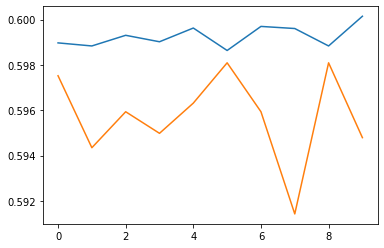

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [18]:
train_eval_result = model.evaluate(dict(train_df), train_df['Sentiment'])
validation_eval_result = model.evaluate(dict(validation_df), validation_df['Sentiment'])

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

493/493 [==============================] - 1s 3ms/step - loss: 0.9759 - accuracy: 0.5948
Training set accuracy: 0.5994440913200378
Validation set accuracy: 0.5947920083999634


Make predictions

In [0]:
# Make predictions
test_df = pd.read_csv('test.tsv', sep='\t')
test_predictions = model.predict(dict(test_df))
test_predictions = np.argmax(test_predictions, axis=-1)

result_df = pd.read_csv('sampleSubmission.csv')

result_df["Sentiment"] = test_predictions

result_df.to_csv("predictions.csv", index=False)

In [25]:
# Export submissions to csv file
import b7
export_file = 'predictions.csv'
b7.Files().upload_vps(export_file)
print("DONE ", arrow.now())

[05-19 03:45:02     INFO] predictions.csv was uploaded


DONE  2020-05-19T03:45:02.635009+00:00
